# Load data

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Constants
DATASET_URL = "mask_bool_data"

BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = (224, 224, 3)

VALIDATION_SPLIT = 0.2

EPOCHS = 15
FINE_TUNE_EPICHS = 5


In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode='nearest',
    validation_split=0.2
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
	horizontal_flip=True,
	fill_mode='nearest',
    validation_split=0.2
)

overall_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
	horizontal_flip=True,
	fill_mode='nearest',
)


train_generator = train_datagen.flow_from_directory(
    DATASET_URL,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
)
val_generator = val_datagen.flow_from_directory(
    DATASET_URL,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
)
all_generator = overall_datagen.flow_from_directory(
    DATASET_URL,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

Found 1096 images belonging to 2 classes.
Found 273 images belonging to 2 classes.
Found 1369 images belonging to 2 classes.


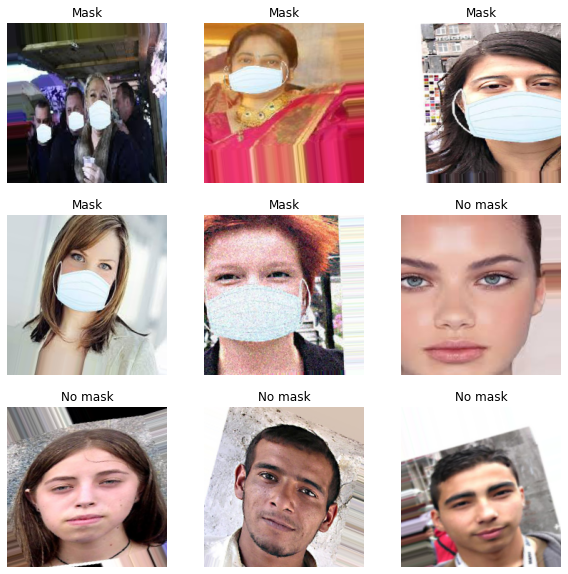

In [4]:
# Show sample images
class_names = ['Mask', 'No mask']

plt.figure(figsize=(10, 10))
images, labels = train_generator.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i] / 255)
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

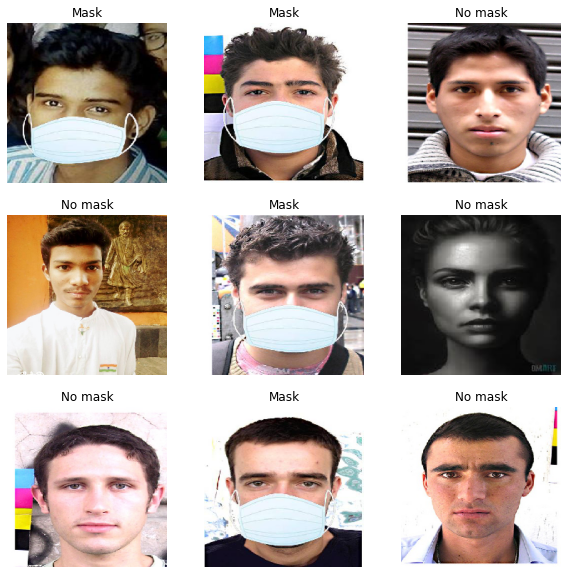

In [5]:
plt.figure(figsize=(10, 10))
images, labels = val_generator.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i] / 255)
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

# Prepare model

In [6]:
# Load model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet'
)

In [7]:
# Freeze model weights
base_model.trainable = False

# Classification head

In [8]:
# Flatten via average pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Get prdiction using Dense layer
prediction_layer = tf.keras.layers.Dense(2)

# Build model

In [9]:
# Build functional model
inputs = tf.keras.Input(shape=IMAGE_SHAPE)  # Input
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs) # Preprocess images
x = base_model(x, training=False)      # InceptionResNetV2 model
x = global_average_layer(x)                 # Flatten via average pooling
x = tf.keras.layers.Dense(128, activation='relu')(x)    # Added dense layer
x = tf.keras.layers.Dropout(0.5)(x)         # Dropout
outputs = prediction_layer(x)               # output prediction via Dense layer

model = tf.keras.Model(inputs, outputs)

In [10]:
# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

# Train model

In [12]:
# Get initial state
loss0, accuracy0 = model.evaluate(val_generator)

# Print initial state
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

9/9 [==============================] - 4s 293ms/step - loss: 3.2083 - accuracy: 0.5509
initial loss: 3.14
initial accuracy: 0.53


In [13]:
# Fit model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

Epoch 1/15
35/35 [==============================] - 17s 416ms/step - loss: 6.2096 - accuracy: 0.5082 - val_loss: 4.5156 - val_accuracy: 0.5018
Epoch 2/15
35/35 [==============================] - 13s 357ms/step - loss: 5.4581 - accuracy: 0.6223 - val_loss: 4.6263 - val_accuracy: 0.8828
Epoch 3/15
35/35 [==============================] - 13s 359ms/step - loss: 6.3780 - accuracy: 0.5794 - val_loss: 6.5230 - val_accuracy: 0.5018
Epoch 4/15
35/35 [==============================] - 13s 361ms/step - loss: 4.9247 - accuracy: 0.6980 - val_loss: 0.8648 - val_accuracy: 0.9377
Epoch 5/15
35/35 [==============================] - 12s 351ms/step - loss: 4.7694 - accuracy: 0.6770 - val_loss: 4.3884 - val_accuracy: 0.5934
Epoch 6/15
35/35 [==============================] - 13s 356ms/step - loss: 4.3527 - accuracy: 0.7372 - val_loss: 1.6910 - val_accuracy: 0.9487
Epoch 7/15
35/35 [==============================] - 14s 394ms/step - loss: 3.5841 - accuracy: 0.8066 - val_loss: 1.0160 - val_accuracy: 0.9231

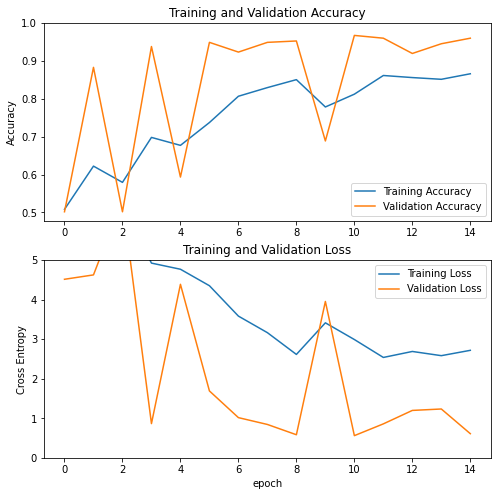

In [14]:
# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tune

In [15]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [16]:
# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze only and all the layers before the `fine_tune_at` layer
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [17]:
# Compile model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [19]:
# Continue traiing the model
total_epochs = EPOCHS + FINE_TUNE_EPICHS

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator
)

Epoch 15/20
35/35 [==============================] - 18s 449ms/step - loss: 0.3077 - accuracy: 0.9443 - val_loss: 0.0092 - val_accuracy: 0.9963
Epoch 16/20
35/35 [==============================] - 15s 419ms/step - loss: 0.0340 - accuracy: 0.9939 - val_loss: 0.0355 - val_accuracy: 0.9890
Epoch 17/20
35/35 [==============================] - 15s 433ms/step - loss: 0.0057 - accuracy: 0.9995 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 18/20
35/35 [==============================] - 16s 442ms/step - loss: 0.0164 - accuracy: 0.9987 - val_loss: 0.0452 - val_accuracy: 0.9927
Epoch 19/20
35/35 [==============================] - 16s 442ms/step - loss: 0.0109 - accuracy: 0.9963 - val_loss: 0.0460 - val_accuracy: 0.9817
Epoch 20/20
35/35 [==============================] - 15s 428ms/step - loss: 0.0295 - accuracy: 0.9968 - val_loss: 0.0529 - val_accuracy: 0.9927


In [20]:
# Learning curves
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

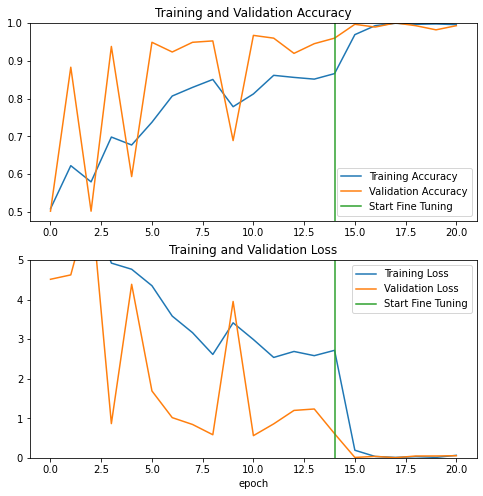

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.plot([EPOCHS - 1,EPOCHS - 1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([EPOCHS - 1,EPOCHS - 1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
# Evaluate
model.evaluate(val_generator)

9/9 [==============================] - 2s 244ms/step - loss: 0.0526 - accuracy: 0.9927


[0.05263468250632286, 0.9926739931106567]

In [23]:
model.evaluate(all_generator)

43/43 [==============================] - 11s 250ms/step - loss: 0.0097 - accuracy: 0.9985


[0.009749557822942734, 0.9985390901565552]

In [24]:
# Save model
model.save('../model/mask_pred.h5')

0
[1. 0.]


(-0.5, 223.5, 223.5, -0.5)

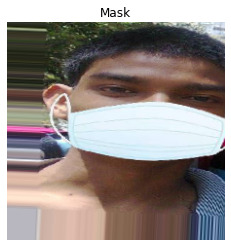

In [25]:
# Show sample images
import numpy as np

class_names = ['Mask', 'No mask']

images, labels = train_generator.next()
image = np.expand_dims(images[0], axis=0)
print(np.argmax(model(image)))
print(labels[0])

plt.imshow(np.squeeze(image / 255))
plt.title(class_names[np.argmax(labels[0])])
plt.axis("off")

# Custom image check

In [26]:
import cv2
img = cv2.imread('test_image.png')
img2 = cv2.imread('test_image2.png')

In [27]:
# import tensorflow as tf
# model = tf.keras.models.load_model('../model/mask_pred')

In [28]:
import numpy as np

# Resize
img = cv2.resize(img, (224, 224))
img2 = cv2.resize(img2, (224, 224))

# # Normalize
# img = img / 255.0
# img2 = img2 / 255.0

# Expand dims
img = np.expand_dims(img, axis=0)
img2 = np.expand_dims(img2, axis=0)

In [29]:
print(img.shape)
print(img2.shape)

(1, 224, 224, 3)
(1, 224, 224, 3)


In [30]:
print((model(img)))
print((model(img2)))

tf.Tensor([[-7.373091   2.0642025]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 20.115316 -29.160702]], shape=(1, 2), dtype=float32)
